In [1]:
# Imports

import os
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.optimize import least_squares 
import math
import numpy as np
from natsort import natsorted
from dicom_parser import Header
import dicom2nifti

Here are some **tips** to run the code smoothly with no (or very few) changes:

- **Required data** to run this code is: dicom series, nifti image file and nifti mask file

- Make sure you **change all paths** in the code when using for the first time. 

- File names should contain a **case identifier, sequence type name and roi name** (if you have several rois) for the code to work. Here you have an example:

    - Case identifier -> Case1
    - Sequence type name -> ME_gp2_ (for a multi-echo grappa sequence)
    - roi name -> placenta
 
Feel free to adapt the code to your needs!


In [36]:
# Case name
case_name = "AB_20220718"

# T2star sequence type (non-accelerated, grappa, grappa+sms)
sequence_type = "ME_p1_"

# Region of interest
roi = "placenta"

# Directory to DICOM and NIFTI data
dicom_directory = "C:/Users/jv21/Desktop/PhD/Scans/FreeMax/"+ case_name +"/"+ sequence_type + roi
nifti_directory = "C:/Users/jv21/Desktop/PhD/Scans/FreeMax/"+ case_name +"/"+ case_name + "_" + sequence_type + roi + ".nii.gz"

# Reader - read all of the DICOM metadata information, including private data (multiple series possible)
reader = sitk.ImageSeriesReader()
series_ids = reader.GetGDCMSeriesIDs(dicom_directory)
dicom_names = reader.GetGDCMSeriesFileNames(dicom_directory,series_ids[0])
reader.SetFileNames(dicom_names)
reader.MetaDataDictionaryArrayUpdateOn()
reader.LoadPrivateTagsOn()
main_image = reader.Execute()
meta_keys = reader.GetMetaDataKeys(0)

Image shape is: (9, 22, 100, 100)


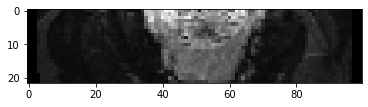

In [37]:
# Read Image
main_image_arr = sitk.GetArrayFromImage(main_image)

# Image shape
print('Image shape is:',main_image_arr.shape)

# Show one slice
plt.imshow(main_image_arr[0,:,50,:], cmap='gray')

In [38]:
# Extra functions/variables 

# The way dicom data is stored might chang, thus some changes might need to be done in this section.

# Find number of measurements
nO_meas = main_image_arr.shape[0]

# Find number of echoes (works for 3 & 5 echoes, change if needed)
if (nO_meas % 5 == 0):
    nO_echoes = 5
elif (nO_meas % 3 == 0):
    nO_echoes = 3

# Find number of slices 
nO_slices = main_image_arr.shape[1]

#  Find x and y dimensions
x_dim = main_image_arr.shape[2]
y_dim = main_image_arr.shape[3]

# Get TE array
TE_array = []

for i in range(nO_echoes):
    header = Header(dicom_names[i])
    csa_TE = header.get('PerFrameFunctionalGroupsSequence')[0]['MREchoSequence'][0]
    TE = int(csa_TE.get('EffectiveEchoTime'))
    TE_array.append(TE)

print('Number of echoes is:', nO_echoes)
print('TEs are:', TE_array)

Number of echoes is: 3
TEs are: [81, 225, 369]


In [39]:
# Crop image to region of interest

ROI_path = "C:/Users/jv21/Desktop/PhD/Analysis/FreeMax/" + case_name + "/" + case_name + "_"+ "ME_" + roi + "_mask.nii.gz"
crop_path = "C:/Users/jv21/Desktop/PhD/Analysis/FreeMax/" + case_name + "/" 

nifti_image = sitk.ReadImage(nifti_directory)
image_array = sitk.GetArrayFromImage(nifti_image)
roi_image = sitk.ReadImage(ROI_path)
roi_array = sitk.GetArrayFromImage(roi_image)

crop_images = np.zeros((nO_echoes,(x_dim*y_dim*nO_slices)))

for i in range(nO_echoes):
    image_array[i][roi_array==0]=0
    flat_array = np.ndarray.flatten(image_array[i])
    crop_images[i,:] = flat_array

# Find nonzero voxel idx
nz_idx = []

for i in range(crop_images.shape[1]):
    sol = (crop_images[:,i]!=0).all()
    if (sol == True):
        nz_idx.append(i)
    else:
        pass    

In [40]:
# In case you want to visualize the cropped images you can save them

crop_path = "C:/Users/jv21/Desktop/PhD/Analysis/FreeMax/" + case_name + "/" + "Cropped/"

for i in range(nO_echoes):
    image_array[i][roi_array==0]=0
    crop_image =sitk.GetImageFromArray(image_array[i])
    crop_image.CopyInformation(nifti_image[:,:,:,0])
    crop_image_path = crop_path + case_name + "_" + sequence_type + "_" + roi + "_" + "TE" + str(i) + "_crop.nii.gz"
    sitk.WriteImage(crop_image, crop_image_path)


In [41]:
# T2 fit function

def t2fit(X,data,TEs):
    TEs=np.array(TEs,dtype=float)
    X=np.array(X,dtype=float)
    S = X[0] * ((np.exp(-(TEs/X[1]))))                  
    return data - S

def t2fiteval(X, TEs):
    TEs=np.array(TEs,dtype=float)
    X=np.array(X,dtype=float)
    S = X[0] * ((np.exp(-(TEs/X[1]))))                  
    return S

In [42]:
# Obtain T2 map

T2_map = np.zeros((2,(x_dim*y_dim*nO_slices)))

for i in range(len(nz_idx)):
    pix_array = crop_images[:,nz_idx[i]]
    param_init = np.squeeze([pix_array[0], np.average(TE_array)])
    result = least_squares(t2fit, param_init, args = (pix_array,TE_array), bounds=([0,0],[10000,1000]))
    T2_map[0,nz_idx[i]]= result.x[0]
    T2_map[1,nz_idx[i]]= result.x[1]


In [43]:
# Obtain T2 map residuals

T2_residuals_all = np.zeros((1,(x_dim*y_dim*nO_slices)))
T2_residuals = np.zeros((1,len(nz_idx)))

for i in range(len(nz_idx)):
    pix_array = crop_images[:,nz_idx[i]]
    result = [T2_map[0,nz_idx[i]] , T2_map[1,nz_idx[i]]]
    fit = t2fiteval(result, TE_array)
    #residual = np.sqrt(np.sum((((pix_array - fit)**2)/nO_echoes))
    residual = 100*(np.sum(np.abs((pix_array - fit)/pix_array)/nO_echoes))
    T2_residuals_all[:,nz_idx[i]] = residual
    T2_residuals[:,i] = residual

2.7316336690946574
32.53344739329136


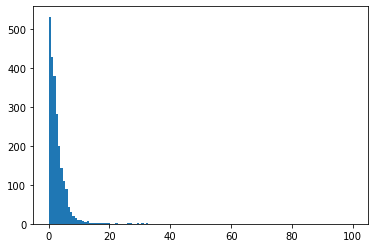

In [44]:
# Obtain an histogram of the residuals 
n, bins,patches = plt.hist(np.array(T2_residuals[0]),bins = 128, range= (0,100))

# Print mean and maximum value of T2 residuals
print(np.mean(np.abs(T2_residuals)))
print(np.max(np.abs(T2_residuals)))

In [45]:
#Save T2 map

t2map_path =  "C:/Users/jv21/Desktop/PhD/Analysis/FreeMax/" + case_name + "/" + case_name +"_" + sequence_type + roi + "_t2map.nii.gz"

t2_val = T2_map[1,:]
t2_val = np.reshape(t2_val, (nO_slices,x_dim,y_dim))
image = sitk.GetImageFromArray(t2_val)
image.CopyInformation(nifti_image[:,:,:,0])
sitk.WriteImage(image,t2map_path)

In [46]:
#Save T2 map residuals

t2residual_path =  "C:/Users/jv21/Desktop/PhD/Analysis/FreeMax/" + case_name + "/" + case_name +"_" + sequence_type + roi + "_residualmap.nii.gz"

t2_r = np.reshape(T2_residuals_all, (nO_slices,x_dim,y_dim))
image = sitk.GetImageFromArray(t2_r)
image.CopyInformation(nifti_image[:,:,:,0])
sitk.WriteImage(image,t2residual_path)